In [1]:
# -- IMPORTS -- #
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image as kerasImage
from keras.layers import Dense
from keras.models import Model
from keras.activations import relu
from tensorflow.python.framework import ops
from PIL import Image as pilImage
import keras.backend as K
import os
import random
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# -- CREATE DIRECTORY -- #
if not os.path.isdir('./Results/Smooth'):
    os.mkdir('./Results/Smooth')
    
# -- DEFINE FUNCTIONS -- #
def load_image(path,targetSize=(224,224),preprocess=True):
    data = kerasImage.load_img(path,target_size=targetSize)
    if preprocess:
        data = kerasImage.img_to_array(data)
        data = np.expand_dims(data,axis=0)
        #data = preprocess_input(data)
    return data

def deprocess_image(x):
    x -= x.mean(); x /= (x.std() + K.epsilon()); x *= 0.1
    # CLIP DATA
    x += 0.5; x = np.clip(x, 0, 1)
    # CONVERT TO RGB
    x *= 255; x = np.clip(x, 0, 255).astype('uint8')
    return x

def visualize_heatmap(image,heatmap,sinImg,savePath):
    fig = plt.figure(figsize=(10, 8))
    plt.subplot(131)
    plt.title('Original')
    plt.axis('off')
    plt.imshow(image)
    plt.subplot(132)
    plt.title('SmoothGrad')
    plt.axis('off')
    plt.imshow(deprocess_image(heatmap.copy()),cmap='bone',interpolation='bilinear')
    plt.subplot(133)
    plt.title('Gradient')
    plt.axis('off')
    plt.imshow(deprocess_image(sinImg.copy()),cmap='bone',interpolation='bilinear')
    fig.savefig(savePath,dpi=250)

In [3]:
model = VGG16(weights='imagenet',include_top=True)

Instructions for updating:
Colocations handled automatically by placer.


In [42]:
# -- GET MODEL INFO -- #
layerName = 'block5_conv3'
inputData = model.inputs[0]
outputLayer = model.get_layer(layerName)
loss = K.mean(outputLayer.output)
gradients = K.gradients(loss, inputData)[0]
smooth = K.function([inputData], [gradients])

In [22]:
# -- INPUT IMAGE -- #
selImg = input('Select the test image: ')
imgData = load_image('./Data/images/'+selImg+'.jpg')
image = load_image('./Data/images/'+selImg+'.jpg',preprocess=False)

Select the test image:  test_5


In [39]:
# -- COMPUTE SMOOTHGRAD -- #
samples = int(input('Select the number of iterations: '))
noise = int(input('Select the std for the noise: '))
SmoothGrad = []

for k in range(samples):
    noiseSignal = np.random.normal(0,noise,imgData.shape)
    img = imgData+noiseSignal
    gradVal = smooth([img])[0]
    SmoothGrad.append(gradVal)
    
heatMap = np.mean(np.array(SmoothGrad),axis=0)
heatMap = np.sum(heatMap[0],axis=-1)
heatMap[heatMap < np.mean(heatMap)] = 0
print('DONE')

Select the number of iterations:  50
Select the std for the noise:  10


DONE


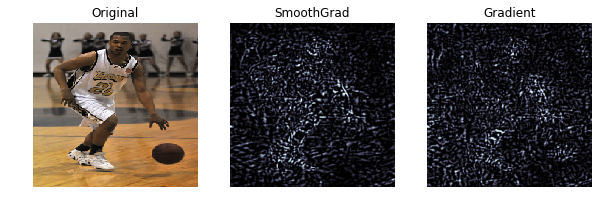

In [40]:
if not os.path.isdir('./Results/BackProp'):
    os.mkdir('./Results/BackProp')
if not os.path.isdir('./Results/Smooth'):
    os.mkdir('./Results/Smooth')
    
savePath = './Results/Smooth/'+selImg+'.png'
sinImg = np.sum(smooth([imgData])[0],axis=-1)
sinImg[sinImg < np.mean(sinImg)] = 0
visualize_heatmap(image,heatMap,sinImg[0],savePath)

In [43]:
# -- Back Propagation -- #
backImg = smooth([imgData])
print(backImg[0].shape)
heatMap = np.sum(backImg[0],axis=-1)
print(heatMap.shape)
heatMap[heatMap < np.mean(heatMap)] = 0
saveBPath = './Results/BackProp/'+selImg+'_'+layerName+'.png'
fig = plt.figure(figsize=(6, 4))
plt.subplot(121)
plt.title('Original')
plt.axis('off')
plt.imshow(image)
plt.subplot(122)
plt.title('Gradient')
plt.axis('off')
plt.imshow(deprocess_image(heatMap.copy())[0],cmap='bone',interpolation='bilinear')
fig.savefig(saveBPath,dpi=250)

(1, 224, 224, 3)
(1, 224, 224)


In [52]:
normHeat = (heatMap)/heatMap.max()
normHeat = 1-normHeat
normHeat[normHeat>1] = 1
print(normHeat)
print(normHeat.max(),normHeat.min())
newImg = imgData[0,:,:,:]*normHeat[...,np.newaxis]
print(newImg.shape)

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
1.0 0.0
(1, 224, 224, 3)


In [58]:
pred = model.predict(imgData)
print(pred[0][4])
pred = model.predict(newImg)
print(pred[0][4])

0.65127456
0.00035971543
